In [48]:
from IPython.display import Image, display, Markdown

In [1]:
from langchain_core.tools.base import BaseToolkit

Decompose the Problem: CoT prompts guide the model to break down a complex question into manageable steps, akin to how a human might solve the problem.
Guide with Exemplars: CoT uses examples that demonstrate reasoning steps, helping the model grasp the method needed to reach the correct answer.

Zero-Shot CoT and CoT Prompting both aim to improve model responses and extract more accurate answers by generating logic-based reasoning. In Zero-Shot CoT, however, we do not have to include input exemplars of Chain-of-Thought responses, but rather just append the words "Let's think step by step" to the end of an input.

Example:

> If John has 5 pears, then eats 2, and buys 5 more, then gives 3 to his friend, how many pears does he have?
> 
> Let's think step by step.

In [4]:
import os
import pandas as pd
import numpy as np
from typing import TypedDict, List, Optional, Dict, Any
from sklearn.impute import SimpleImputer
from langgraph.graph import StateGraph, END


In [5]:

# --- 1. Define Agent State ---

class CleaningState(TypedDict):
    """Represents the state of our data cleaning pipeline."""
    file_path: str               # Input CSV file path
    dataframe: Optional[pd.DataFrame] # The data being processed
    report: List[str]            # Log of actions performed
    null_threshold: float        # % threshold to drop columns
    imputation_results: Optional[Dict[str, Any]] # Store imputer details

# --- 2. Define Cleaning Tool Functions (as Nodes) ---

def load_data(state: CleaningState) -> Dict[str, Any]:
    """Loads the initial data from the CSV file."""
    print("--- Node: load_data ---")
    file_path = state['file_path']
    report = state.get('report', []) # Initialize report if not present
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded data. Shape: {df.shape}")
        report.append(f"Loaded data from '{file_path}'. Initial shape: {df.shape}")
        return {"dataframe": df, "report": report}
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        report.append(f"Error: File not found at {file_path}. Stopping execution.")
        # Returning None for dataframe signals an issue, could also raise an exception
        # or add an error flag to the state if graph needs more complex error handling.
        return {"dataframe": None, "report": report}
    except Exception as e:
        print(f"Error loading CSV: {e}")
        report.append(f"Error loading CSV: {e}. Stopping execution.")
        return {"dataframe": None, "report": report}

def drop_high_null_columns(state: CleaningState) -> Dict[str, Any]:
    """Drops columns exceeding the null value threshold."""
    print("--- Node: drop_high_null_columns ---")
    df = state['dataframe']
    report = state['report']
    threshold = state['null_threshold']

    if df is None:
        report.append("Skipping drop_high_null_columns: DataFrame not loaded.")
        print("Skipping: DataFrame not loaded.")
        return {"report": report} # No change to dataframe

    initial_cols = df.shape[1]
    null_percentages = df.isnull().mean()
    cols_to_drop = null_percentages[null_percentages > threshold].index.tolist()

    if cols_to_drop:
        df = df.drop(columns=cols_to_drop)
        dropped_cols_str = ", ".join(cols_to_drop)
        report.append(f"Dropped columns with >{threshold*100}% nulls: [{dropped_cols_str}].")
        print(f"Dropped columns: {cols_to_drop}")
        print(f"New shape: {df.shape}")
    else:
        report.append(f"No columns found with >{threshold*100}% null values.")
        print("No columns to drop based on threshold.")

    return {"dataframe": df, "report": report}

def drop_all_null_rows(state: CleaningState) -> Dict[str, Any]:
    """Drops rows where all values are null."""
    print("--- Node: drop_all_null_rows ---")
    df = state['dataframe']
    report = state['report']

    if df is None:
        report.append("Skipping drop_all_null_rows: DataFrame not available.")
        print("Skipping: DataFrame not available.")
        return {"report": report}

    initial_rows = df.shape[0]
    df = df.dropna(how='all')
    rows_dropped = initial_rows - df.shape[0]

    if rows_dropped > 0:
        report.append(f"Dropped {rows_dropped} rows containing all null values.")
        print(f"Dropped {rows_dropped} all-null rows.")
        print(f"New shape: {df.shape}")
    else:
        report.append("No rows found containing all null values.")
        print("No all-null rows to drop.")

    return {"dataframe": df, "report": report}


def impute_missing_values(state: CleaningState) -> Dict[str, Any]:
    """Imputes missing values (NaN and empty strings) based on column type."""
    print("--- Node: impute_missing_values ---")
    df = state['dataframe']
    report = state['report']
    imputation_summary = {} # Store details about imputation

    if df is None:
        report.append("Skipping impute_missing_values: DataFrame not available.")
        print("Skipping: DataFrame not available.")
        return {"report": report}

    # Replace empty strings with NaN to be caught by imputation
    df = df.replace(r'^\s*$', np.nan, regex=True)
    report.append("Replaced empty strings with NaN for imputation.")
    print("Replaced empty strings with NaN.")

    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    categorical_cols = df.select_dtypes(include='object').columns.tolist() # Simple typing

    imputed_cols_count = 0

    # Impute Numeric Columns (using median)
    if numeric_cols:
        num_imputer = SimpleImputer(strategy='median')
        # Only impute columns that actually have NaNs
        numeric_cols_with_nan = df[numeric_cols].isnull().any()
        cols_to_impute_num = numeric_cols_with_nan[numeric_cols_with_nan].index.tolist()
        if cols_to_impute_num:
            print(f"Imputing numeric columns (median): {cols_to_impute_num}")
            df[cols_to_impute_num] = num_imputer.fit_transform(df[cols_to_impute_num])
            imputation_summary['numeric_median'] = cols_to_impute_num
            imputed_cols_count += len(cols_to_impute_num)
        else:
            print("No numeric columns require imputation.")


    # Impute Categorical Columns (using most frequent)
    if categorical_cols:
        cat_imputer = SimpleImputer(strategy='most_frequent')
         # Only impute columns that actually have NaNs
        categorical_cols_with_nan = df[categorical_cols].isnull().any()
        cols_to_impute_cat = categorical_cols_with_nan[categorical_cols_with_nan].index.tolist()
        if cols_to_impute_cat:
            print(f"Imputing categorical columns (most_frequent): {cols_to_impute_cat}")
            df[cols_to_impute_cat] = cat_imputer.fit_transform(df[cols_to_impute_cat])
            imputation_summary['categorical_most_frequent'] = cols_to_impute_cat
            imputed_cols_count += len(cols_to_impute_cat)
        else:
            print("No categorical columns require imputation.")

    if imputed_cols_count > 0:
        report.append(f"Imputed missing values in {imputed_cols_count} column(s). Details: {imputation_summary}")
    else:
        report.append("No missing values found requiring imputation.")

    return {"dataframe": df, "report": report, "imputation_results": imputation_summary}



In [8]:
workflow = StateGraph(CleaningState)

workflow.add_node("load", load_data)
workflow.add_node("drop_cols", drop_high_null_columns)
workflow.add_node("drop_rows", drop_all_null_rows)
workflow.add_node("impute", impute_missing_values)

# Define the sequence of execution
workflow.set_entry_point("load")
workflow.add_edge("load", "drop_cols")
workflow.add_edge("drop_cols", "drop_rows")
workflow.add_edge("drop_rows", "impute")
workflow.add_edge("impute", END)

# Compile the graph
cleaning_agent = workflow.compile()


In [ ]:
data = {
    'ID': [1, 2, 3, 4, 5, 6, 7],
    'Name': ['Alice', 'Bob', '', 'David', 'Eve', 'Frank', 'Grace'],
    'Age': [25, 30, 35, None, 28, 45, 50],
    'City': ['New York', 'London', 'Paris', 'London', '', 'Sydney', None],
    'Salary': [50000, 60000, 75000, None, 55000, None, 90000],
    'HighNullCol': [None, None, None, None, None, 'Value', None], # >70% null
    'AllNullRowIndicator': [None, None, None, None, None, None, None] # Used to create an all-null row later
}
sample_df = pd.DataFrame(data)
all_null_row = pd.Series([None] * len(sample_df.columns), index=sample_df.columns)
sample_df = pd.concat([sample_df, pd.DataFrame([all_null_row])], ignore_index=True)


sample_df['AllNullRowIndicator'] = None


csv_file_path = "sample_data_to_clean.csv"
sample_df.to_csv(csv_file_path, index=False)

print(f"Created sample CSV: {csv_file_path}")
print("--- Original Data ---")
print(sample_df)
print("-" * 30)


In [ ]:
initial_state: CleaningState = {
    "file_path": csv_file_path,
    "dataframe": None,
    "report": [],
    "null_threshold": 0.7,
    "imputation_results": None
}

print("\n--- Starting Cleaning Agent ---")
final_state = cleaning_agent.invoke(initial_state)
print("\n--- Cleaning Agent Finished ---")


print("\n--- Final Report ---")
for msg in final_state['report']:
    print(f"- {msg}")

print("\n--- Final Cleaned Data ---")
if final_state['dataframe'] is not None:
    print(final_state['dataframe'])
    final_state['dataframe'].to_csv("sample_data_to_clean_cleaned.csv")
    print(f"\nFinal Shape: {final_state['dataframe'].shape}")
    print("\nNull values after cleaning:")
    print(final_state['dataframe'].isnull().sum())
else:
    print("Data cleaning could not be completed due to errors.")

In [10]:
import os
import operator
import pandas as pd
import numpy as np
from typing import TypedDict, Annotated, Sequence, Optional, Dict, Any
from dotenv import load_dotenv

from langchain_groq import ChatGroq
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END
from langgraph.pregel import RunnableConfig
from sklearn.impute import SimpleImputer

In [13]:
import getpass
import os

os.environ["GROQ_API_KEY"] = getpass.getpass()

LLAMA_8B = "llama3-8b-8192"
LLAMA_70B = "llama3-70b-8192"
GEMMA2_9B = "gemma2-9b-it"

model = ChatGroq(model=LLAMA_8B)

 ········


In [14]:
llm = model

In [32]:
def get_data_summary(df: dict) -> str:
    """Generates a concise summary of the DataFrame for the LLM."""
    if df is None:
        return "No data loaded."

    df = pd.DataFrame.from_dict(df)
    summary = []
    summary.append(f"DataFrame Shape: {df.shape}")
    null_counts = df.isnull().sum()
    empty_string_counts = (df == '').sum()
    total_missing = null_counts + empty_string_counts
    missing_summary = total_missing[total_missing > 0].sort_values(ascending=False)

    if not missing_summary.empty:
        summary.append("\nMissing Values (NaN or ''):")
        for col, count in missing_summary.items():
            percent = (count / df.shape[0]) * 100
            summary.append(f"- {col}: {count} ({percent:.2f}%)")
    else:
        summary.append("\nNo missing values (NaN or '') found.")

    summary.append("\nColumn Data Types:")
    summary.append(df.dtypes.to_string())

    # Add preview of first few rows for context
    summary.append("\nData Preview (first 3 rows):")
    summary.append(df.head(3).to_string())

    return "\n".join(summary)

# --- 2. Define Cleaning Tools ---

def drop_high_null_columns(df: dict, null_threshold_percent: float = 50.0) -> Dict[str, Any]:
    """
    Drops columns from the DataFrame where the percentage of missing values
    (NaN or empty string) exceeds the specified threshold.
    Args:
        df (pd.DataFrame): The input DataFrame.
        null_threshold_percent (float): The percentage threshold (0-100). Default is 50.
    Returns:
        Dict[str, Any]: A dictionary containing the modified DataFrame under the key 'dataframe'
                        and a status message under the key 'status'.
    """
    print(f"--- Calling drop_high_null_columns (threshold: {null_threshold_percent}%) ---")
    if df is None:
         return {"dataframe": None, "status": "Error: No DataFrame provided."}

    df = pd.DataFrame.from_dict(df)
    # Consider both NaN and empty strings as missing
    df_copy = df.replace('', np.nan)
    initial_cols = set(df_copy.columns)
    threshold = null_threshold_percent / 100.0
    cols_to_drop = []

    for col in df_copy.columns:
        null_ratio = df_copy[col].isnull().sum() / len(df_copy)
        if null_ratio > threshold:
            cols_to_drop.append(col)

    if not cols_to_drop:
        status = f"No columns found with missing values > {null_threshold_percent}%."
        print(f"--- Status: {status} ---")
        return {"dataframe": df, "status": status} # Return original df if no changes
    else:
        df_cleaned = df.drop(columns=cols_to_drop) # Drop from the original df
        dropped_cols_str = ", ".join(cols_to_drop)
        status = f"Dropped {len(cols_to_drop)} columns ({dropped_cols_str}) with > {null_threshold_percent}% missing values."
        print(f"--- Status: {status} ---")
        return {"dataframe": df_cleaned.to_dict(), "status": status}

def drop_all_null_rows(df: dict) -> Dict[str, Any]:
    """
    Drops rows from the DataFrame where all values are missing (NaN or empty string).
    Args:
        df (pd.DataFrame): The input DataFrame.
    Returns:
        Dict[str, Any]: A dictionary containing the modified DataFrame under the key 'dataframe'
                        and a status message under the key 'status'.
    """
    print("--- Calling drop_all_null_rows ---")
    if df is None:
         return {"dataframe": None, "status": "Error: No DataFrame provided."}

    df = pd.DataFrame.from_dict(df)

    initial_rows = len(df)
    # Replace empty strings with NaN to use dropna effectively
    df_copy = df.replace('', np.nan)
    df_cleaned_temp = df_copy.dropna(how='all')

    # Get the indices of rows that were kept
    kept_indices = df_cleaned_temp.index

    # Use the kept indices to filter the original DataFrame (preserving original values like '')
    df_cleaned = df.loc[kept_indices]

    rows_dropped = initial_rows - len(df_cleaned)

    if rows_dropped > 0:
        status = f"Dropped {rows_dropped} rows where all values were missing."
    else:
        status = "No all-missing rows found to drop."

    print(f"--- Status: {status} ---")
    return {"dataframe": df_cleaned.to_dict(), "status": status}


def impute_missing_values(df: dict) -> Dict[str, Any]:
    """
    Imputes missing values (NaN or empty string) in the DataFrame.
    Uses median for numerical columns and mode (most frequent) for categorical/object columns.
    Args:
        df (pd.DataFrame): The input DataFrame.
    Returns:
        Dict[str, Any]: A dictionary containing the modified DataFrame under the key 'dataframe'
                        and a status message under the key 'status'.
    """
    print("--- Calling impute_missing_values ---")
    if df is None:
         return {"dataframe": None, "status": "Error: No DataFrame provided."}

    df = pd.DataFrame.from_dict(df)

    df_cleaned = df.copy()
    df_cleaned = df_cleaned.replace('', np.nan) # Treat empty strings as NaN for imputation

    imputed_cols = []
    numerical_cols = df_cleaned.select_dtypes(include=np.number).columns
    categorical_cols = df_cleaned.select_dtypes(include=['object', 'category']).columns

    # Impute numerical columns
    if not df_cleaned[numerical_cols].isnull().sum().sum() == 0:
        num_imputer = SimpleImputer(strategy='median')
        df_cleaned[numerical_cols] = num_imputer.fit_transform(df_cleaned[numerical_cols])
        imputed_cols.extend([col for col in numerical_cols if df[col].replace('', np.nan).isnull().any()]) # Check original df for missingness
        print(f"--- Imputed numerical columns (median): {[col for col in numerical_cols if df[col].replace('', np.nan).isnull().any()]} ---")

    # Impute categorical columns
    if not df_cleaned[categorical_cols].isnull().sum().sum() == 0:
        cat_imputer = SimpleImputer(strategy='most_frequent')
        df_cleaned[categorical_cols] = cat_imputer.fit_transform(df_cleaned[categorical_cols])
        imputed_cols.extend([col for col in categorical_cols if df[col].replace('', np.nan).isnull().any()]) # Check original df for missingness
        print(f"--- Imputed categorical columns (mode): {[col for col in categorical_cols if df[col].replace('', np.nan).isnull().any()]} ---")

    if imputed_cols:
        status = f"Imputed missing values in columns: {', '.join(sorted(list(set(imputed_cols))))} (Numerical: Median, Categorical: Mode)."
    else:
        status = "No missing values found to impute."

    print(f"--- Status: {status} ---")
    return {"dataframe": df_cleaned.to_dict(), "status": status}


tools = [drop_high_null_columns, drop_all_null_rows, impute_missing_values]



In [35]:
from langchain_core.tools.base import BaseTool

In [37]:
class DropColumnTool(BaseTool):
    name: str = "drop_high_null_columns"
    description: str = """
    Drops columns from the DataFrame where the percentage of missing values
    (NaN or empty string) exceeds the specified threshold.
    """
    def _run(self, df):
        return drop_high_null_columns(df)


class DropRowTool(BaseTool):
    name: str = "drop_all_null_rows"
    description: str = """
    Drops rows from the DataFrame where all values are missing (NaN or empty string).
    """
    def _run(self, df):
        return drop_all_null_rows(df)


class ImputeTool(BaseTool):
    name: str = "drop_all_null_rows"
    description: str = """
    Imputes missing values (NaN or empty string) in the DataFrame.
    Uses median for numerical columns and mode (most frequent) for categorical/object columns.
    """
    def _run(self, df):
        return impute_missing_values(df)

tools = [DropColumnTool(), DropRowTool(), ImputeTool()]
tools

[DropColumnTool(), DropRowTool(), ImputeTool()]

In [38]:
[t.name for t in tools]

['drop_high_null_columns', 'drop_all_null_rows', 'drop_all_null_rows']

In [54]:
# --- 3. Define Agent State ---
class DataCleaningState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    dataframe: pd.DataFrame  # The actual data being cleaned
    data_summary: str        # Text summary for the LLM
    original_file_path: str  # Keep track of the source


def call_data_cleaning_agent(state: DataCleaningState, config: RunnableConfig):
    """Invokes the LLM to decide the next cleaning step or generate a final response."""
    print("--- Calling LLM Agent ---")
    messages = state['messages']

    current_summary = state['data_summary']  # Provide the latest data summary to the LLM
    summary_message = HumanMessage(content=f"Here is the current state of the data:\n\n{current_summary}\n\nBased *only* on this summary, what cleaning step should be taken next using the available tools? If the data looks sufficiently clean (e.g., no obvious high null columns, no all-null rows needing removal, and imputation has been attempted if needed), respond with a final assessment and do not call any tools.")

    model = llm
    model_with_tools = model.bind_tools(tools)
    llm_messages = messages + [summary_message]

    print("--- Sending to LLM ---")
    print("Messages sent: ")
    print([m.pretty_repr() for m in llm_messages])
    response: AIMessage = model_with_tools.invoke(llm_messages, config=config)
    print(f"--- LLM Response: {response.content} ---")
    print(f"--- LLM Tool Calls: {response.tool_calls} ---")

    return {"messages": [response]}

# Node 2: Executes tools
def execute_cleaning_tool(state: DataCleaningState):
    """Executes the cleaning tool called by the LLM."""
    print("--- Executing Tool ---")
    last_message: AIMessage = state['messages'][-1] # Get the latest AI message

    if not last_message.tool_calls:
        print("--- ERROR: No tool calls found in the last message, but Action node was reached. ---")
        # This case should ideally not be reached due to the conditional edge
        # Add a message indicating potential confusion or end of planned tool use
        no_tool_message = ToolMessage(content="No tool call was specified by the agent in the previous step.", tool_call_id="error_no_tool")
        return {"messages": [no_tool_message]}

    tool_messages: List[ToolMessage] = []
    current_df = state['dataframe'] # Get the dataframe to operate on
    new_df = current_df # Start with the current df

    for tool_call in last_message.tool_calls:
        tool_name = tool_call["name"]
        print(f"--- Preparing Tool: {tool_name} ---")
        print(f"--- Arguments: {tool_call['args']} ---")

        selected_tool = None
        for t in tools:
            if t.name == tool_name:
                selected_tool = t
                break

        if selected_tool:
            try:
                tool_output_dict = selected_tool.invoke({**tool_call["args"], "df": new_df})
                new_df = tool_output_dict.get("dataframe", new_df)
                status_message = tool_output_dict.get("status", "Tool executed but provided no status.")

                print(f"--- Tool Status: {status_message} ---")
                tool_messages.append(
                    ToolMessage(content=status_message, tool_call_id=tool_call["id"])
                )
            except Exception as e:
                print(f"--- ERROR executing tool {tool_name}: {e} ---")
                error_message = f"Error executing tool {tool_name}: {str(e)}"
                tool_messages.append(
                    ToolMessage(content=error_message, tool_call_id=tool_call["id"])
                )
        else:
            print(f"--- ERROR: Tool '{tool_name}' not found ---")
            tool_messages.append(
                 ToolMessage(content=f"Error: Tool '{tool_name}' not found.", tool_call_id=tool_call["id"])
            )

    new_summary = get_data_summary(new_df)
    print("--- Data Summary Updated ---")

    return {
        "messages": tool_messages,
        "dataframe": new_df,
        "data_summary": new_summary,
    }

def should_continue_cleaning(state: DataCleaningState) -> str:
    """Determines whether to continue cleaning (call a tool) or end."""
    print("--- Checking Condition: Should Continue Cleaning? ---")
    last_message = state['messages'][-1]

    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        print("--- Decision: Continue (Execute Tool) ---")
        return "execute_tool"
    else:
        print("--- Decision: End Cleaning Cycle ---")
        return END


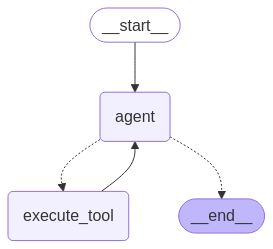

In [55]:
workflow = StateGraph(DataCleaningState)
workflow.add_node("agent", call_data_cleaning_agent)
workflow.add_node("execute_tool", execute_cleaning_tool)

workflow.set_entry_point("agent")
workflow.add_conditional_edges(
    "agent",
    should_continue_cleaning,
    {
        "execute_tool": "execute_tool",
        END: END
    }
)
workflow.add_edge("execute_tool", "agent")
data_cleaning_app = workflow.compile()

display(Image(data_cleaning_app.get_graph().draw_mermaid_png()))

def run_data_cleaning_agent(file_path: str, output_file_path: str = "cleaned_data.csv"):
    """Loads data, runs the cleaning agent, and saves the result."""
    print(f"\n--- Starting Data Cleaning for: {file_path} ---")

    df = pd.read_csv(file_path)
    initial_summary = get_data_summary(df)
    initial_state = DataCleaningState(
        messages=[
            SystemMessage(content="You are an expert data cleaning agent. Your goal is to iteratively clean the provided dataset using the available tools (`drop_high_null_columns`, `drop_all_null_rows`, `impute_missing_values`). Analyze the data summary provided at each step and decide the most appropriate cleaning action. Ask for clarification if needed, but prioritize using the tools to address issues like high null percentages, all-null rows, or missing values needing imputation. When you believe the data is sufficiently clean based on the summary, provide a final response summarizing the cleaning process and state that cleaning is complete, without calling any more tools."),
            HumanMessage(content=f"Please clean the data from the file: {os.path.basename(file_path)}. Start by analyzing the initial summary.")
        ],
        dataframe=df,
        data_summary=initial_summary,
        original_file_path=file_path
    )

    print("\n--- Running Cleaning Workflow ---")
    final_state = None
    config = RunnableConfig(recursion_limit=10) 
    step_counter = 0
    max_steps = 8

    for output in data_cleaning_app.stream(initial_state, config=config, stream_mode="values"):
        step_counter += 1
        print(f"\n--- Cleaning Step {step_counter} Completed ---")
        last_node = list(output.keys())[-1]
        print(f"--- Last Node Executed: {last_node} ---")
        # print(f"--- Current Data Shape: {output['dataframe'].shape if output['dataframe'] is not None else 'N/A'} ---")
        # print("--- Current Messages ---")
        # for msg in output['messages']:
        #      print(f"  {msg.type.upper()}: {msg.content[:150]}...") # Print truncated message content
        # print("-" * 30)
        final_state = output # Keep track of the latest state
        if step_counter >= max_steps:
            print(f"--- Reached maximum steps ({max_steps}), stopping execution. ---")
            break

    if final_state is None:
         print("--- ERROR: Workflow did not produce a final state. ---")
         return

    # --- Process Final Result ---
    print("\n--- Cleaning Workflow Finished ---")
    final_df = final_state['dataframe']
    final_summary = final_state['data_summary']
    final_messages = final_state['messages']

    print("\n--- Final Data Summary ---")
    print(final_summary)

    print("\n--- Final Agent Message ---")
    if final_messages and isinstance(final_messages[-1], AIMessage):
        print(final_messages[-1].content)
    elif final_messages and isinstance(final_messages[-1], ToolMessage):
         print(f"(Ended after tool execution: {final_messages[-1].content})")
    else:
        print("(No final AI message found)")

    if final_df is not None:
        final_df.to_csv(output_file_path, index=False)
        print(f"\n--- Cleaned data saved to: {output_file_path} ---")
    else:
        print("--- WARNING: Final DataFrame is None, nothing to save. ---")



In [56]:
# --- 9. Example Usage ---

# Create a dummy CSV for testing
dummy_data = {
    'ID': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'Name': ['Alice', 'Bob', '', 'David', 'Eve', 'Frank', 'Grace', 'Heidi', 'Ivan', 'Judy'],
    'Age': [25, 30, 35, None, 28, 45, 22, 38, '', 50],
    'City': ['NY', 'SF', 'LA', 'NY', None, 'SF', 'LA', 'SF', 'NY', ''],
    'Salary': [50000, 60000, 70000, 55000, None, 90000, 45000, 80000, 65000, None],
    'HighNullCol': [None] * 7 + [1, 2, 3], # >50% null
    'AllNullRowIndicator': [None] * 10, # To test row drop
    'MixedNulls': [10, None, 30, '', 50, None, 70, 80, 90, 100]
}
dummy_df = pd.DataFrame(dummy_data)
# Add an all-null row
all_null_row = pd.DataFrame([[None]*len(dummy_df.columns)], columns=dummy_df.columns)
dummy_df = pd.concat([dummy_df, all_null_row], ignore_index=True)

# Add another all-null row with empty strings
all_empty_row = pd.DataFrame([['']*len(dummy_df.columns)], columns=dummy_df.columns)
dummy_df = pd.concat([dummy_df, all_empty_row], ignore_index=True)

dummy_csv_path = "dummy_data_to_clean.csv"
dummy_df.to_csv(dummy_csv_path, index=False)
print(f"Created dummy CSV: {dummy_csv_path}")

# Run the agent on the dummy CSV
run_data_cleaning_agent(dummy_csv_path, output_file_path="cleaned_dummy_data.csv")

C:\Users\thars\AppData\Local\Temp\ipykernel_18760\2353215087.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dummy_df = pd.concat([dummy_df, all_null_row], ignore_index=True)


Created dummy CSV: dummy_data_to_clean.csv

--- Starting Data Cleaning for: dummy_data_to_clean.csv ---

--- Running Cleaning Workflow ---

--- Cleaning Step 1 Completed ---
--- Last Node Executed: original_file_path ---
--- Calling LLM Agent ---
--- Sending to LLM ---
Messages sent: 
['================================ System Message ================================\n\nYou are an expert data cleaning agent. Your goal is to iteratively clean the provided dataset using the available tools (`drop_high_null_columns`, `drop_all_null_rows`, `impute_missing_values`). Analyze the data summary provided at each step and decide the most appropriate cleaning action. Ask for clarification if needed, but prioritize using the tools to address issues like high null percentages, all-null rows, or missing values needing imputation. When you believe the data is sufficiently clean based on the summary, provide a final response summarizing the cleaning process and state that cleaning is complete, without c

AttributeError: 'dict' object has no attribute 'to_csv'

In [28]:
from langchain_core.utils.function_calling import convert_to_openai_function, convert_to_openai_tool

In [31]:
def foo(df: dict):
    return df


convert_to_openai_tool(foo)

{'type': 'function',
 'function': {'name': 'foo',
  'description': '',
  'parameters': {'properties': {'df': {'type': 'object'}},
   'required': ['df'],
   'type': 'object'}}}